# CoDA (uncertainty‑aware) in 2ACDC near/far — Fig. 4c/4i/4j (OSM‑style)

This notebook upgrades the CoDA simulation to the **uncertainty‑aware split rule** (posterior/Wilson test on `P(US|CS)`), based on your latest code. It reproduces **Fig. 4c** (clean transition graph), **Fig. 4i** (final correlation quantification), and **Fig. 4j** (decorrelation order).

### What changed vs. the previous notebook
- **Split rule now uses uncertainty:** for each state `s`, we compute a candidate outcome `u* = argmax_u P(u|s)`.   We then require statistical evidence that `P(u*|s) > θ_split` using either a **Beta‑posterior** test or, if special functions   are unavailable, a **Wilson lower bound** test on the proportion (successes = co‑occurrences with `u*`, failures = with other US).   Additional gates on **presence episodes** and **effective exposure** are included.
- The plotting & evaluation remain the same (OSM‑style Fig. 4c; Fig. 4i/4j blocks & threshold = 0.3).

In [1]:

import math, random, collections
from dataclasses import dataclass
from typing import Dict, List, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try optional math for Beta CDF; fall back to Wilson
try:
    from mpmath import betainc, erfcinv
    _HAS_MPMATH = True
except Exception:
    _HAS_MPMATH = False

random.seed(0); np.random.seed(0)


In [2]:

def posterior_prob_p_greater_than(theta: float, success: float, failure: float, alpha0: float=0.5, beta0: float=0.5) -> float:
    """P(p > theta | Beta(alpha0+success, beta0+failure)). Requires mpmath; else returns 0 for fallback to Wilson."""
    if not _HAS_MPMATH:
        return 0.0
    a = alpha0 + max(0.0, float(success))
    b = beta0 + max(0.0, float(failure))
    cdf = betainc(a, b, 0, theta, regularized=True)
    return float(1.0 - cdf)

def wilson_lower_bound(phat: float, n: float, confidence: float=0.95) -> float:
    """Lower bound of a proportion at the given confidence. If no mpmath, use z≈1.64485 (~95%)."""
    if n <= 0:
        return 0.0
    z = 1.6448536269514722  # ~95%
    denom = 1.0 + (z*z)/n
    center = phat + (z*z)/(2.0*n)
    adj = z * ((phat*(1.0-phat) + (z*z)/(4.0*n))/n)**0.5
    return (center - adj)/denom


## Sun et al. task — near/far symbol sequences & block indices

In [3]:

near = [1,1,1,1,1,1, 2,2,2,2, 1,1,1, 4, 6, 1,1,1, 5,5, 1,1, 7, 0,0,0]
far  = [1,1,1,1,1,1, 3,3,3,3, 1,1,1, 4,4, 1,1,1, 5, 6, 1,1, 7, 0,0,0]
assert len(near)==len(far)==26

preR1_idx = list(range(10,13))   # between indicator and R1 visual
preR2_idx = list(range(15,18))   # between (R1/water) and R2 visual

def block_indices(rows, cols): return [(r,c) for r in rows for c in cols]
offdiag_pairs     = block_indices(preR1_idx, preR2_idx) + block_indices(preR2_idx, preR1_idx)
same_preR1_pairs  = block_indices(preR1_idx, preR1_idx)
same_preR2_pairs  = block_indices(preR2_idx, preR2_idx)

symbols = sorted(set(near)|set(far))
symbols


[0, 1, 2, 3, 4, 5, 6, 7]

## CoDA (uncertainty‑aware split rule)

- Tracks co‑occurrence (contextual eligibility) for **US ∈ {4,5}**.
- **Split gate** for state `s`:
  1) Sufficient **exposure** and **presence**; 2) choose `u* = argmax_u P(u|s)`; 3) either
     `P(p>θ_split | Beta)` ≥ `confidence` *(if available)* **or** Wilson lower bound of `phat` exceeds `θ_split`.
- On split, **clone immediate successors** along the same path; downstream splits propagate iteratively.

In [4]:

@dataclass
class UncConfig:
    gamma: float = 0.9
    lam: float = 0.8
    theta_split: float = 0.9
    confidence: float = 0.95
    alpha0: float = 0.5
    beta0: float = 0.5
    n_threshold: int = 5                # min total co-occ counts before even considering split
    min_presence_episodes: int = 3
    min_effective_exposure: float = 10.0
    reset_symbols: tuple = (0,)

class CoDAAgentUncertain:
    def __init__(self, obs_symbols, cfg: UncConfig=UncConfig()):
        self.cfg = cfg
        self.reset_symbols = set(cfg.reset_symbols)
        # Latent states
        self.states = {}                 # id -> {'obs':int, 'path':None/'R1'/'R2', 'parent':Optional[int]}
        self.obs_to_state_ids = {o: [] for o in obs_symbols}
        sid = 0
        for o in obs_symbols:
            self.states[sid] = {'obs': o, 'path': None, 'parent': None}
            self.obs_to_state_ids[o].append(sid)
            sid += 1
        self._next_sid = sid
        
        # co-occurrence counts with US ∈ {4,5}
        self.us_classes = [4,5]
        self.co_occ = {s: {u: 0.0 for u in self.us_classes} for s in self.states}   # successes vs others
        self.exposure = {s: 0.0 for s in self.states}                                # total elig mass across US events
        self.presence_episodes = {s: 0 for s in self.states}                         # in how many episodes did s appear
        self.salient = {}  # s -> 'R1'/'R2'
        
        # for Fig. 4c: keep nothing heavy; we will reconstruct canonical paths on demand
    
    def _ensure_state(self, sid):
        if sid not in self.co_occ:
            self.co_occ[sid] = {u:0.0 for u in self.us_classes}
            self.exposure[sid] = 0.0
            self.presence_episodes[sid] = 0
    
    def _clone_state(self, orig_state_id: int, path: str) -> int:
        orig = self.states[orig_state_id]
        clone_id = self._next_sid
        self.states[clone_id] = {'obs': orig['obs'], 'path': path, 'parent': orig_state_id}
        self.obs_to_state_ids[orig['obs']].append(clone_id)
        self._ensure_state(clone_id)
        self._next_sid += 1
        return clone_id
    
    def _select_state_for_obs(self, obs: int, context: Optional[str]) -> int:
        cands = self.obs_to_state_ids[obs]
        if context is not None:
            for sid in cands:
                if self.states[sid]['path'] == context:
                    return sid
        for sid in cands:
            if self.states[sid]['path'] is None:
                return sid
        return cands[0]
    
    def run_episode(self, obs_seq: List[int], learn=True):
        context = None
        latent_seq = []
        visited = set()
        for obs in obs_seq:
            sid = self._select_state_for_obs(obs, context)
            latent_seq.append(sid)
            visited.add(sid)
            if sid in self.salient:
                context = self.salient[sid]
            if obs in self.reset_symbols:
                context = None
        
        if not learn:
            return latent_seq
        
        # Presence-episodes gate
        for sid in visited:
            self.presence_episodes[sid] = self.presence_episodes.get(sid, 0) + 1
        
        # Identify US event indices
        us_positions = {4: [i for i,o in enumerate(obs_seq) if o==4],
                        5: [i for i,o in enumerate(obs_seq) if o==5]}
        
        # Contextual eligibility accumulation per US event
        for u, pos_list in us_positions.items():
            for t_us in pos_list:
                e = np.zeros(self._next_sid, dtype=float)
                for t in range(t_us+1):
                    sid = latent_seq[t]
                    e *= (self.cfg.gamma * self.cfg.lam)
                    e[sid] += 1.0
                # record exposure mass for all states in trace
                for s_id, val in enumerate(e):
                    if val>0 and s_id in self.states:
                        self._ensure_state(s_id)
                        self.co_occ[s_id][u] += val
                        self.exposure[s_id] += val
        
        # Compute P(u|s)
        P = {}
        for s in self.states:
            tot = sum(self.co_occ[s][u] for u in self.us_classes)
            P[s] = {u: (self.co_occ[s][u]/tot if tot>0 else 0.0) for u in self.us_classes}
        
        # Uncertainty-aware split
        newly_salient = []
        for s in list(self.states.keys()):
            if s in self.salient:
                continue
            tot = sum(self.co_occ[s][u] for u in self.us_classes)
            if tot < self.cfg.n_threshold:
                continue
            if self.presence_episodes.get(s,0) < self.cfg.min_presence_episodes:
                continue
            if self.exposure.get(s,0.0) < self.cfg.min_effective_exposure:
                continue
            
            u_star = max(self.us_classes, key=lambda u: P[s][u])
            success = self.co_occ[s][u_star]
            failure = tot - success
            phat = success / (tot if tot>0 else 1.0)
            pass_test = False
            if _HAS_MPMATH:
                post = posterior_prob_p_greater_than(self.cfg.theta_split, success, failure,
                                                     self.cfg.alpha0, self.cfg.beta0)
                pass_test = (post >= self.cfg.confidence)
            if not pass_test:
                lb = wilson_lower_bound(phat, n=tot, confidence=self.cfg.confidence)
                pass_test = (lb > self.cfg.theta_split)
            
            if pass_test:
                path = 'R1' if u_star==4 else 'R2'
                self.salient[s] = path
                newly_salient.append((s, path))
        
        # Propagate splitting: clone the immediate successor after each occurrence of s
        for s, path in newly_salient:
            # reconstruct the latent sequence again (no learning) to find successors following s
            context = None
            for t, obs in enumerate(obs_seq[:-1]):
                sid = self._select_state_for_obs(obs, context)
                if sid == s:
                    next_obs = obs_seq[t+1]
                    cands = self.obs_to_state_ids[next_obs]
                    if not any(self.states[c]['path']==path for c in cands):
                        self._clone_state(cands[0], path)
                if sid in self.salient:
                    context = self.salient[sid]
                if obs_seq[t+1] in self.reset_symbols:
                    context = None
        
        return latent_seq
    
    # ---------- analysis helpers ----------
    def encode_sequence(self, obs_seq: List[int]) -> np.ndarray:
        lat = self.run_episode(obs_seq, learn=False)
        S = self._next_sid
        X = np.zeros((len(lat), S), dtype=float)
        for t, sid in enumerate(lat):
            X[t, sid] = 1.0
        return X[:, :self._next_sid]
    
    def near_far_corr(self, near_seq, far_seq) -> np.ndarray:
        A = self.encode_sequence(near_seq); B = self.encode_sequence(far_seq)
        C = np.zeros((A.shape[0], B.shape[0]))
        for i in range(A.shape[0]):
            for j in range(B.shape[0]):
                a = A[i]; b = B[j]
                if np.allclose(a,0) or np.allclose(b,0):
                    C[i,j] = 0.0
                else:
                    a0 = a - a.mean(); b0 = b - b.mean()
                    denom = (np.linalg.norm(a0)*np.linalg.norm(b0))
                    C[i,j] = (a0@b0)/denom if denom>0 else 0.0
        return C


## Training & evaluation (OSM Fig. 4i/4j blocks and threshold)

In [5]:

N_RUNS = 8
SESSIONS = 9
TRIALS_PER_SESSION = 80
THRESH = 0.3

def block_mean(C, pairs): 
    return float(np.mean([C[i,j] for (i,j) in pairs])) if pairs else np.nan

rng = np.random.default_rng(123)

all_final_blocks = []
all_time_to_thr  = []
mat_by_session   = {s: [] for s in [1,3,4,9]}
last_agent = None

for run in range(N_RUNS):
    agent = CoDAAgentUncertain(obs_symbols=sorted(set(near)|set(far)),
                               cfg=UncConfig(theta_split=0.9, confidence=0.95,
                                             n_threshold=5, min_presence_episodes=3, min_effective_exposure=10.0))
    tt = {'offdiag': None, 'preR2': None, 'preR1': None}
    for session in range(1, SESSIONS+1):
        episodes = [near]*(TRIALS_PER_SESSION//2) + [far]*(TRIALS_PER_SESSION//2)
        rng.shuffle(episodes)
        for ep in episodes:
            agent.run_episode(ep, learn=True)
        C = agent.near_far_corr(near, far)
        if session in mat_by_session:
            mat_by_session[session].append(C)
        b_off = block_mean(C, offdiag_pairs)
        b_r2  = block_mean(C, same_preR2_pairs)
        b_r1  = block_mean(C, same_preR1_pairs)
        if tt['offdiag'] is None and b_off < THRESH: tt['offdiag'] = session
        if tt['preR2']  is None and b_r2  < THRESH: tt['preR2']  = session
        if tt['preR1']  is None and b_r1  < THRESH: tt['preR1']  = session
    # final
    C_final = agent.near_far_corr(near, far)
    all_final_blocks.append((run, block_mean(C_final, offdiag_pairs),
                                  block_mean(C_final, same_preR2_pairs),
                                  block_mean(C_final, same_preR1_pairs)))
    def norm(x): return x/SESSIONS if x is not None else np.nan
    all_time_to_thr.append((run, norm(tt['offdiag']), norm(tt['preR2']), norm(tt['preR1'])))
    last_agent = agent  # keep one for plotting
blocks_df = pd.DataFrame(all_final_blocks, columns=['run','offdiag','preR2','preR1']).set_index('run')
times_df  = pd.DataFrame(all_time_to_thr, columns=['run','offdiag_t','preR2_t','preR1_t']).set_index('run')

display(blocks_df.describe())
display(times_df.describe())


,offdiag,preR2,preR1
count,8.000000,8.000000,8.000000e+00
mean,0.450568,-0.098864,1.000000e+00
std,0.001607,0.003214,8.392497e-17
min,0.450000,-0.100000,1.000000e+00
25%,0.450000,-0.100000,1.000000e+00
50%,0.450000,-0.100000,1.000000e+00
75%,0.450000,-0.100000,1.000000e+00
max,0.454545,-0.090909,1.000000e+00


,offdiag_t,preR2_t,preR1_t
count,0.0,8.000000,0.0
mean,NaN,0.222222,NaN
std,NaN,0.000000,NaN
min,NaN,0.222222,NaN
25%,NaN,0.222222,NaN
50%,NaN,0.222222,NaN
75%,NaN,0.222222,NaN
max,NaN,0.222222,NaN


## Fig. 4c — clean transition graph (two rails; per‑step nodes; ROI‑cropped)

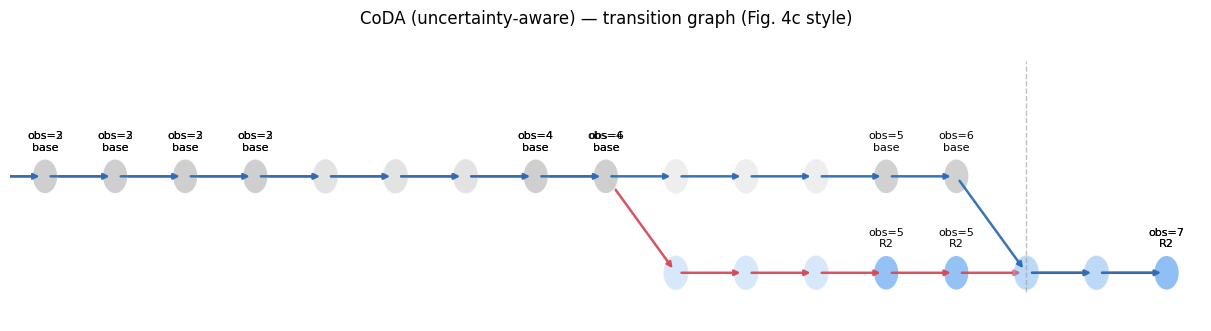

In [6]:

from matplotlib.patches import FancyArrowPatch

def canonical_path_nodes(agent, seq, rail_name):
    lat = agent.run_episode(seq, learn=False)
    nodes = []
    for t, (obs, sid) in enumerate(zip(seq, lat)):
        if obs == 0: break  # stop before teleport
        path = agent.states[sid]['path']
        y = {'R1': 1.0, 'R2': -1.0, None: 0.0}[path]
        nodes.append({'id': f'{rail_name}_{t}', 'sid': sid, 't': t, 'obs': obs,
                      'path': path, 'x': t, 'y': y})
    return nodes

agent_plot = last_agent

near_nodes = canonical_path_nodes(agent_plot, near, 'N')
far_nodes  = canonical_path_nodes(agent_plot,  far, 'F')

near_edges = [(near_nodes[i]['id'], near_nodes[i+1]['id']) for i in range(len(near_nodes)-1)]
far_edges  = [(far_nodes[i]['id'],  far_nodes[i+1]['id'])  for i in range(len(far_nodes)-1)]
pos = {n['id']: (n['x'], n['y']) for n in near_nodes + far_nodes}

fig, ax = plt.subplots(figsize=(12, 3.2), constrained_layout=True)

def draw_path(nodes, edges, edge_color, node_palette):
    for n in nodes:
        c = node_palette.get(n['path'], '#cfcfcf')
        alpha = 0.35 if n['obs']==1 else 0.95
        circ = plt.Circle((n['x'], n['y']), 0.18, facecolor=c, edgecolor='white', linewidth=0.8, alpha=alpha)
        ax.add_patch(circ)
        if n['obs'] in (2,3,4,5,6,7):
            ax.text(n['x'], n['y']+0.25, f'obs={n["obs"]}\n{n["path"] or "base"}', ha='center', va='bottom', fontsize=8)
    for (u,v) in edges:
        x1,y1 = pos[u]; x2,y2 = pos[v]
        arrow = FancyArrowPatch((x1,y1),(x2,y2), arrowstyle='-|>', mutation_scale=8,
                                lw=1.8, color=edge_color, alpha=0.95, shrinkA=4, shrinkB=4)
        ax.add_patch(arrow)

palette = {None:'#cfcfcf','R1':'#ff9bb0','R2':'#8fbff5'}
draw_path(near_nodes, near_edges, '#d64b5a', palette)
draw_path(far_nodes,  far_edges,  '#2f6db3', palette)

# mark split
xs1 = [n['x'] for n in near_nodes if n['path']=='R1']
xs2 = [n['x'] for n in far_nodes  if n['path']=='R2']
if xs1 or xs2:
    split_x = min(xs1 + xs2) if xs1 or xs2 else None
    if split_x is not None:
        ax.plot([split_x, split_x], [-1.2, 1.2], ls='--', lw=1, color='#999', alpha=0.6)

ax.set_xlim(5.5, 22.5)   # ROI crop roughly indicator->R2/wall
ax.set_ylim(-1.5, 1.5)
ax.set_title("CoDA (uncertainty‑aware) — transition graph (Fig. 4c style)")
ax.axis('off'); plt.show()


### Matrices across sessions (sanity check)

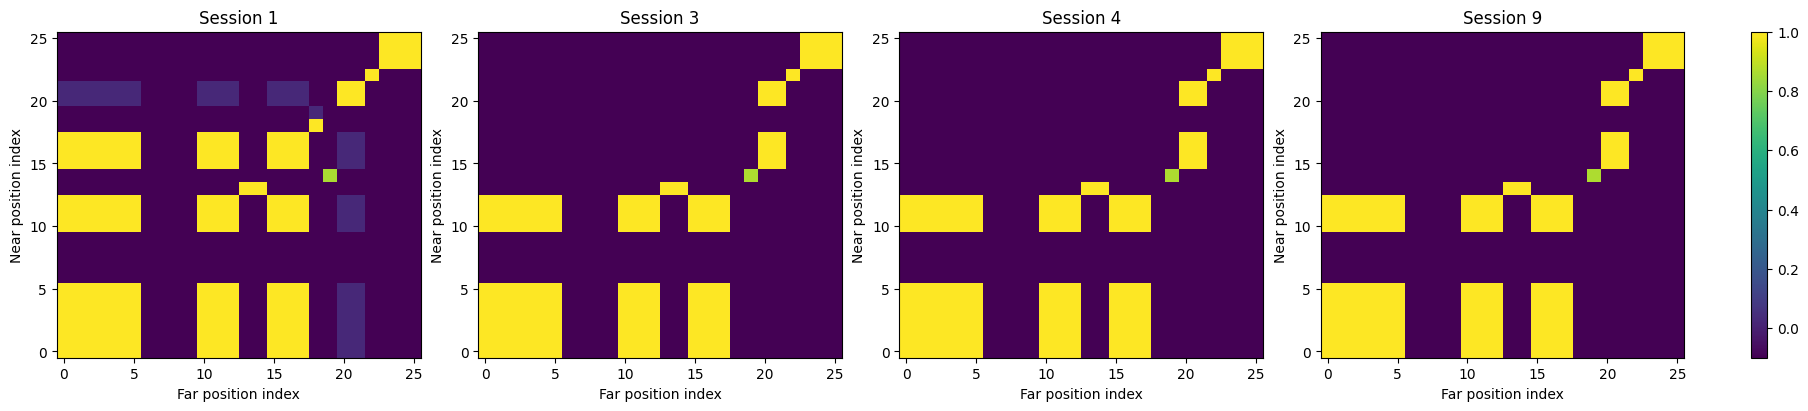

In [7]:

check_sessions = [1,3,4,9]
mean_mats = {s: np.mean(mat_by_session[s], axis=0) for s in check_sessions}

fig, axes = plt.subplots(1, len(check_sessions), figsize=(4.5*len(check_sessions),4), constrained_layout=True)
vmin, vmax = -0.1, 1.0
for ax, s in zip(axes, check_sessions):
    im = ax.imshow(mean_mats[s], vmin=vmin, vmax=vmax, origin='lower', aspect='auto')
    ax.set_title(f"Session {s}")
    ax.set_xlabel("Far position index")
    ax.set_ylabel("Near position index")
fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)
plt.show()


## Fig. 4i — final correlation quantification (bars)

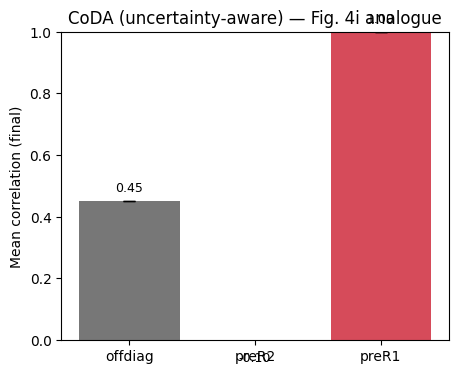

In [8]:

means = blocks_df.mean(); ses = blocks_df.sem()
labels = ['offdiag','preR2','preR1']
x = np.arange(len(labels)); y = [means[l] for l in labels]; yerr = [ses[l] for l in labels]

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylim(0,1.0)
ax.set_ylabel("Mean correlation (final)")
ax.set_title("CoDA (uncertainty‑aware) — Fig. 4i analogue")
for i,val in enumerate(y): ax.text(i, val+0.03, f"{val:.2f}", ha='center', fontsize=9)
plt.show()


## Fig. 4j — decorrelation order (time to < 0.3)

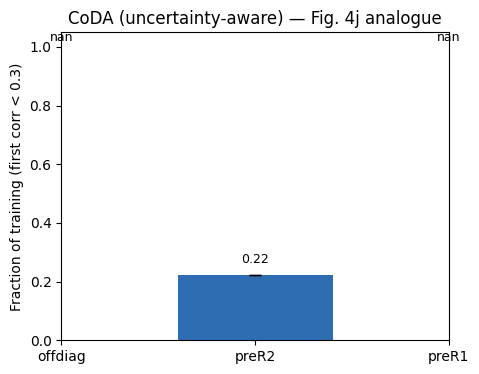

In [9]:

means_t = times_df.mean(skipna=True); ses_t = times_df.sem(skipna=True)
labels = ['offdiag_t','preR2_t','preR1_t']; disp = ['offdiag','preR2','preR1']
x = np.arange(len(labels)); y = [means_t[l] for l in labels]; yerr=[ses_t[l] for l in labels]

fig, ax = plt.subplots(figsize=(5,4))
ax.bar(x, y, yerr=yerr, capsize=4, color=['#777','#2f6db3','#d64b5a'])
ax.set_xticks(x); ax.set_xticklabels(disp)
ax.set_ylim(0,1.05)
ax.set_ylabel("Fraction of training (first corr < 0.3)")
ax.set_title("CoDA (uncertainty‑aware) — Fig. 4j analogue")
for i,val in enumerate(y): ax.text(i, min(1.02,val+0.04), f"{val:.2f}", ha='center', fontsize=9)
plt.show()
